# Prueba Prophet Banco del Bienestar


In [1]:
import pandas as pd
import pyarrow.parquet as pq

# Importar el parquet desde la carpeta Insumos
df = pd.read_parquet('../Insumos/df_general.parquet')


In [5]:
import pandas as pd

# Calendarios oficiales de dispersión
calendarios_oficiales = {
    '2024-07': pd.date_range('2024-07-01', '2024-07-22', freq='D'),
    '2024-09': pd.date_range('2024-09-02', '2024-09-20', freq='D'),
    '2024-11': pd.date_range('2024-11-04', '2024-11-28', freq='D'),
    '2025-01': pd.date_range('2025-01-02', '2025-01-22', freq='D'),
    '2025-03': pd.date_range('2025-03-03', '2025-03-27', freq='D'),
    '2025-09': pd.date_range('2025-09-02', '2025-09-21', freq='D'),
    '2025-11': pd.date_range('2025-11-04', '2025-11-28', freq='D'),
    '2026-01': pd.date_range('2026-01-05', '2026-01-28', freq='D')
}

# Estructura de letras por día
estructura_letras = {
    1: ['A'], 2: ['B'], 3: ['C'], 4: ['C'], 5: ['D', 'E', 'F'],
    6: ['G'], 7: ['G'], 8: ['H', 'I', 'J', 'K'], 9: ['L'],
    10: ['M'], 11: ['M'], 12: ['N', 'Ñ', 'O'], 13: ['P', 'Q'],
    14: ['R'], 15: ['R'], 16: ['S'], 17: ['T', 'U', 'V'],
    18: ['W', 'X', 'Y', 'Z']
}

programas = ['adultos_mayores', 'discapacidad', 'madres_trabajadoras']

# OPCIÓN 1: Holidays desagregados por programa-letra (granular)
holidays_granular = []
for periodo, fechas in calendarios_oficiales.items():
    for idx, fecha in enumerate(fechas, start=1):
        dia_relativo = min(idx, 18)
        letras_dia = estructura_letras.get(dia_relativo, [])
        
        for programa in programas:
            for letra in letras_dia:
                holidays_granular.append({
                    'ds': fecha,
                    'holiday': f'{programa}_{letra}',
                    'lower_window': 0,
                    'upper_window': 3
                })

holidays_df_granular = pd.DataFrame(holidays_granular)

# OPCIÓN 2: Holidays agregados solo por programa (simple)
holidays_agregado = []
for periodo, fechas in calendarios_oficiales.items():
    for fecha in fechas:
        for programa in programas:
            holidays_agregado.append({
                'ds': fecha,
                'holiday': programa,
                'lower_window': 0,
                'upper_window': 3
            })

holidays_df_agregado = pd.DataFrame(holidays_agregado)

print("HOLIDAYS GRANULAR (programa_letra):")
print(f"  Total: {len(holidays_df_granular)}")
print(f"  Únicos: {holidays_df_granular['holiday'].nunique()}")
print(f"  Ejemplos: {holidays_df_granular['holiday'].unique()[:10]}")

print("\nHOLIDAYS AGREGADO (solo programa):")
print(f"  Total: {len(holidays_df_agregado)}")
print(f"  Únicos: {holidays_df_agregado['holiday'].nunique()}")
print(f"  Ejemplos: {holidays_df_agregado['holiday'].unique()}")

HOLIDAYS GRANULAR (programa_letra):
  Total: 1188
  Únicos: 81
  Ejemplos: ['adultos_mayores_A' 'discapacidad_A' 'madres_trabajadoras_A'
 'adultos_mayores_B' 'discapacidad_B' 'madres_trabajadoras_B'
 'adultos_mayores_C' 'discapacidad_C' 'madres_trabajadoras_C'
 'adultos_mayores_D']

HOLIDAYS AGREGADO (solo programa):
  Total: 543
  Únicos: 3
  Ejemplos: ['adultos_mayores' 'discapacidad' 'madres_trabajadoras']


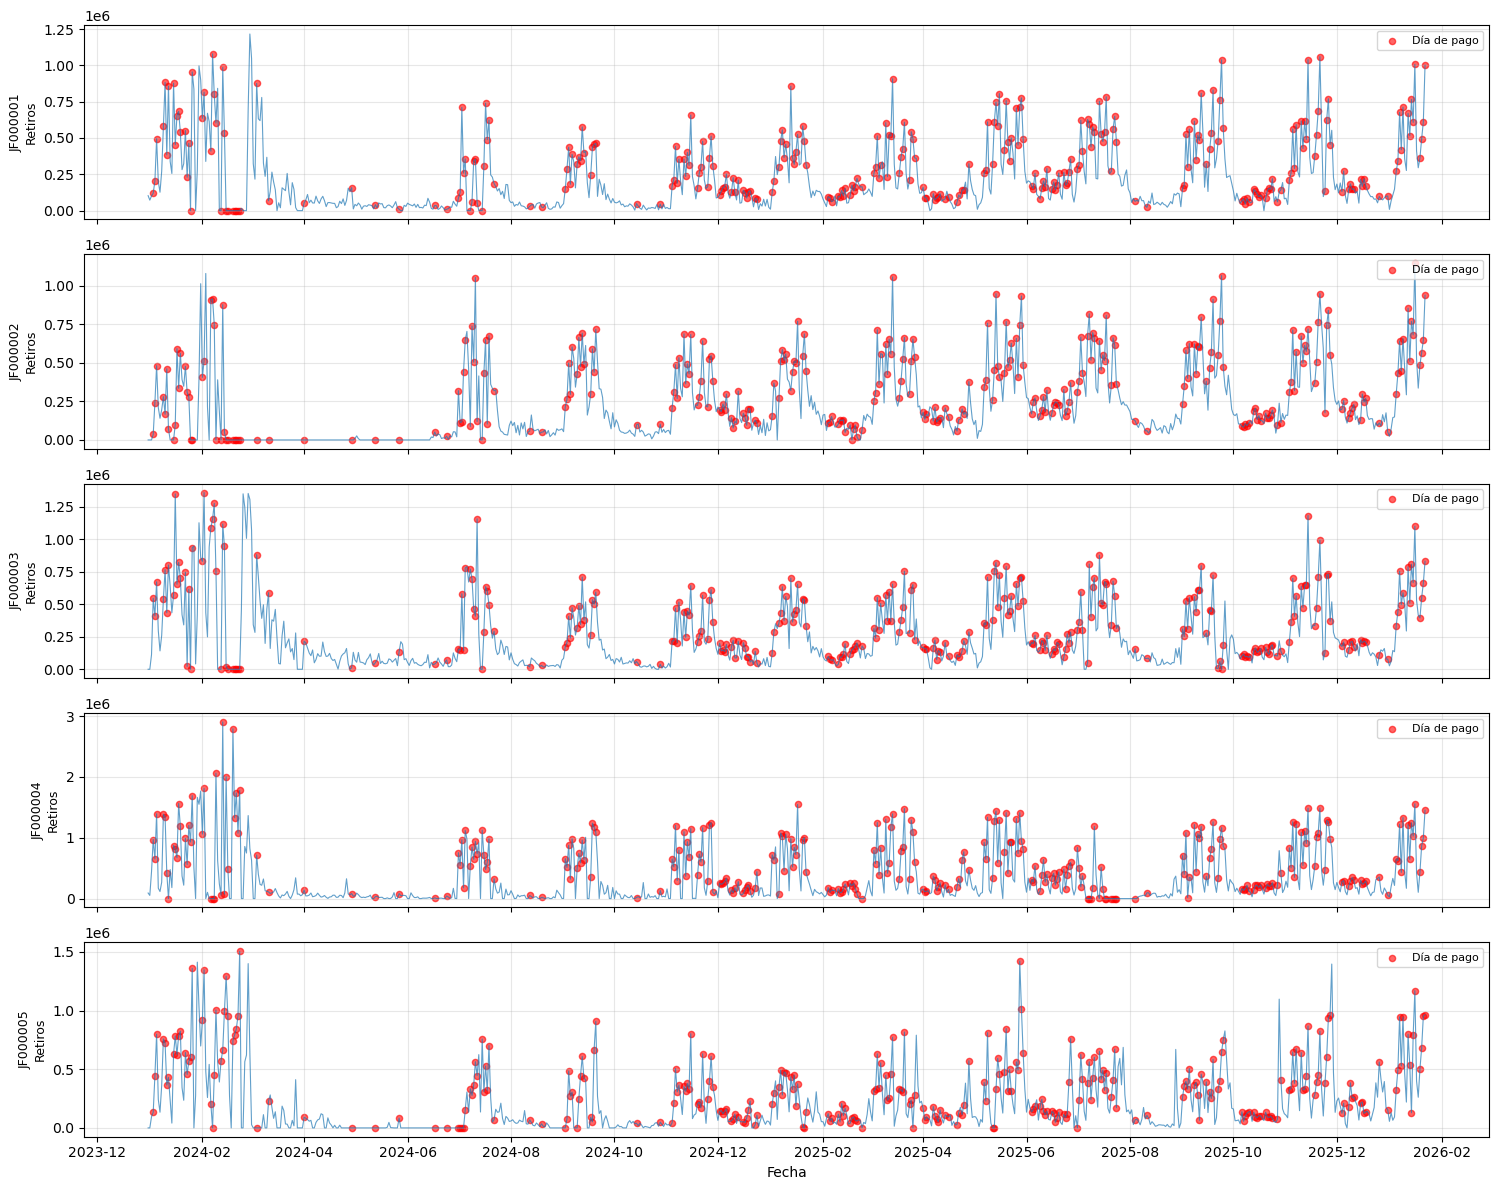


Estadísticas comparativas de cajeros muestra:

JF000001:
  Total retirado: $162,068,750
  % en días de pago: 65.5%
  Retiro promedio día pago: $347,133
  Retiro promedio día NO pago: $124,656

JF000002:
  Total retirado: $169,120,900
  % en días de pago: 66.2%
  Retiro promedio día pago: $366,061
  Retiro promedio día NO pago: $127,469

JF000003:
  Total retirado: $189,193,800
  % en días de pago: 61.9%
  Retiro promedio día pago: $382,491
  Retiro promedio día NO pago: $161,053

JF000004:
  Total retirado: $249,009,900
  % en días de pago: 76.5%
  Retiro promedio día pago: $622,155
  Retiro promedio día NO pago: $130,871

JF000005:
  Total retirado: $161,476,800
  % en días de pago: 67.4%
  Retiro promedio día pago: $355,820
  Retiro promedio día NO pago: $117,401


In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Seleccionar varios cajeros para comparar patrones
cajeros_muestra = ['JF000001', 'JF000002', 'JF000003', 'JF000004', 'JF000005']

fig, axes = plt.subplots(len(cajeros_muestra), 1, figsize=(15, 12), sharex=True)

for i, cajero in enumerate(cajeros_muestra):
    df_cajero_plot = df[df['cajero'] == cajero].sort_values('fecha')
    
    ax = axes[i]
    ax.plot(df_cajero_plot['fecha'], df_cajero_plot['retiro'], linewidth=0.8, alpha=0.7)
    
    # Marcar días de pago con puntos rojos
    dias_pago_cajero = df_cajero_plot[df_cajero_plot['diapago'] == 1]
    ax.scatter(dias_pago_cajero['fecha'], dias_pago_cajero['retiro'], 
               color='red', s=20, alpha=0.6, label='Día de pago')
    
    ax.set_ylabel(f'{cajero}\nRetiros', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    
    # Formato de eje x
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

axes[-1].set_xlabel('Fecha', fontsize=10)
plt.tight_layout()
plt.show()

# Estadísticas comparativas de estos cajeros
print("\nEstadísticas comparativas de cajeros muestra:")
for cajero in cajeros_muestra:
    df_cajero_stats = df[df['cajero'] == cajero]
    total_retiros = df_cajero_stats['retiro'].sum()
    retiros_dias_pago = df_cajero_stats[df_cajero_stats['diapago'] == 1]['retiro'].sum()
    pct_en_dias_pago = (retiros_dias_pago / total_retiros * 100) if total_retiros > 0 else 0
    
    print(f"\n{cajero}:")
    print(f"  Total retirado: ${total_retiros:,.0f}")
    print(f"  % en días de pago: {pct_en_dias_pago:.1f}%")
    print(f"  Retiro promedio día pago: ${df_cajero_stats[df_cajero_stats['diapago']==1]['retiro'].mean():,.0f}")
    print(f"  Retiro promedio día NO pago: ${df_cajero_stats[df_cajero_stats['diapago']==0]['retiro'].mean():,.0f}")

Datos desde 2024-07-01:
  Observaciones: 571
  Rango: 2024-07-01 00:00:00 a 2026-01-22 00:00:00
  Retiro promedio: $221,272
  Retiro mediano: $146,500


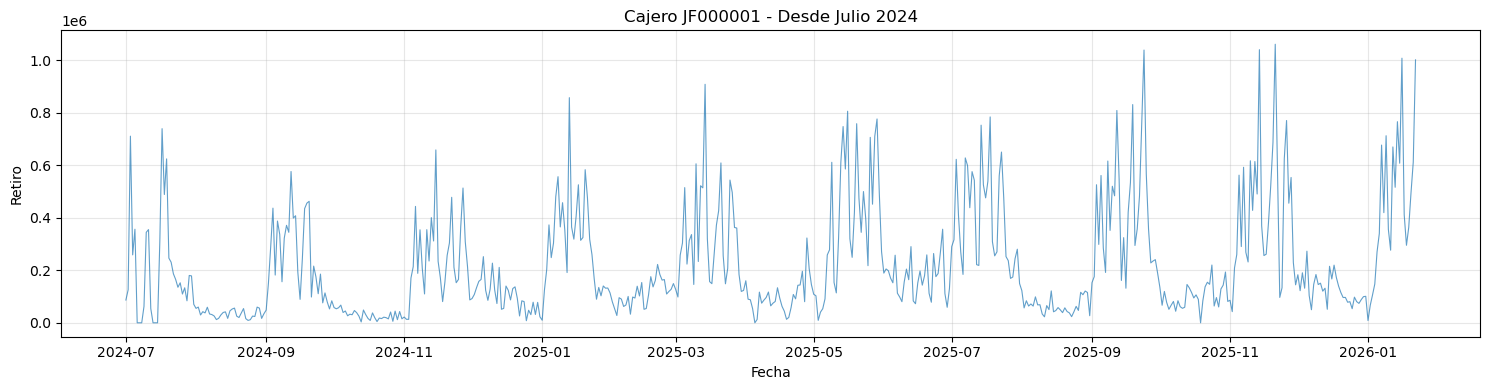

In [23]:
# Entrenar desde julio 2024 con todo el histórico de crecimiento
fecha_inicio = '2024-07-01'

df_modelo = df[df['fecha'] >= fecha_inicio].copy()

cajero_test = 'JF000001'
df_cajero = df_modelo[df_modelo['cajero'] == cajero_test][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

print(f"Datos desde {fecha_inicio}:")
print(f"  Observaciones: {len(df_cajero)}")
print(f"  Rango: {df_cajero['ds'].min()} a {df_cajero['ds'].max()}")
print(f"  Retiro promedio: ${df_cajero['y'].mean():,.0f}")
print(f"  Retiro mediano: ${df_cajero['y'].median():,.0f}")

# Verificar tendencia visual
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 4))
plt.plot(df_cajero['ds'], df_cajero['y'], alpha=0.7, linewidth=0.8)
plt.title(f'Cajero {cajero_test} - Desde Julio 2024')
plt.xlabel('Fecha')
plt.ylabel('Retiro')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Cajero JF000001: 571 observaciones

Configuración: baseline
  n_changepoints: 10
  changepoints_range: 0.9
  trend_reg: 0.1
  n_lags: 21
  yearly_seasonality: 10
  learning_rate: 0.001

GRANULAR: 81 eventos
Entrenando GRANULAR...


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat


AGREGADO: 3 eventos
Entrenando AGREGADO...


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

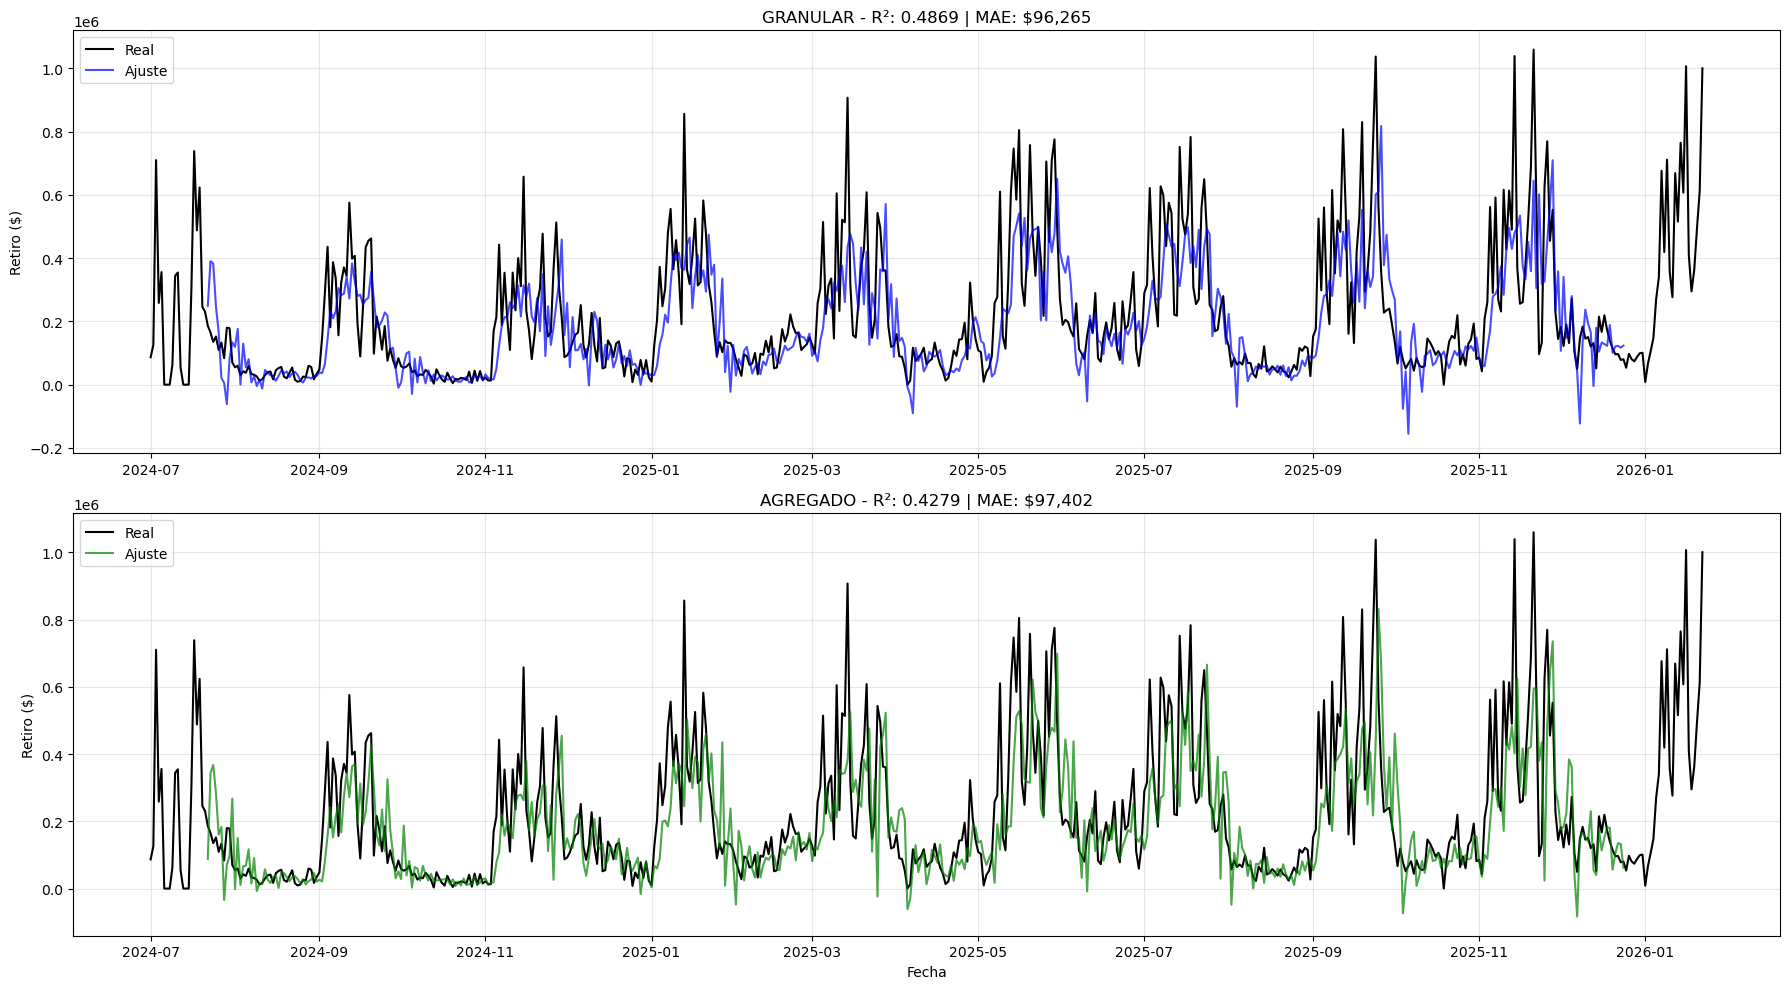


CONFIGURACIÓN: baseline
  GRANULAR - R²: 0.4869 | MAE: $96,265 | RMSE: $141,207
  AGREGADO - R²: 0.4279 | MAE: $97,402 | RMSE: $149,112
  Mejora R²: +13.8%


In [39]:
from neuralprophet import NeuralProphet
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd

# Preparar datos del cajero
fecha_inicio = '2024-07-01'
cajero_test = 'JF000001'

df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

print(f"Cajero {cajero_test}: {len(df_cajero)} observaciones")

# Configuraciones de hiperparámetros
configs = {
    'baseline': {
        'n_changepoints': 10,
        'changepoints_range': 0.9,
        'trend_reg': 0.1,
        'n_lags': 21,
        'yearly_seasonality': 10,
        'learning_rate': 0.001
    },
    'flexible': {
        'n_changepoints': 20,
        'changepoints_range': 0.95,
        'trend_reg': 0.05,
        'n_lags': 28,
        'yearly_seasonality': 15,
        'learning_rate': 0.001
    },
    'conservador': {
        'n_changepoints': 5,
        'changepoints_range': 0.8,
        'trend_reg': 0.5,
        'n_lags': 14,
        'yearly_seasonality': 8,
        'learning_rate': 0.0005
    }
}

config_elegida = 'baseline'
params = configs[config_elegida]

print(f"\nConfiguración: {config_elegida}")
for k, v in params.items():
    print(f"  {k}: {v}")

# ============================================================
# OPCIÓN 1: HOLIDAYS GRANULAR
# ============================================================

df_cajero_granular = df_cajero.copy()

for holiday_name in holidays_df_granular['holiday'].unique():
    fechas_holiday = holidays_df_granular[holidays_df_granular['holiday'] == holiday_name]['ds'].values
    df_cajero_granular[holiday_name] = df_cajero_granular['ds'].isin(fechas_holiday).astype(int)

print(f"\nGRANULAR: {len(holidays_df_granular['holiday'].unique())} eventos")

modelo_granular = NeuralProphet(
    growth='linear',
    n_changepoints=params['n_changepoints'],
    changepoints_range=params['changepoints_range'],
    trend_reg=params['trend_reg'],
    n_forecasts=30,
    n_lags=params['n_lags'],
    yearly_seasonality=params['yearly_seasonality'],
    weekly_seasonality=False,
    daily_seasonality=False,
    epochs=200,
    batch_size=32,
    learning_rate=params['learning_rate'],
    loss_func='Huber',
    normalize='off',
    quantiles=[0.05, 0.95]
)

for holiday_name in holidays_df_granular['holiday'].unique():
    modelo_granular = modelo_granular.add_events(holiday_name)

print("Entrenando GRANULAR...")
metrics_granular = modelo_granular.fit(df_cajero_granular, freq='D')
forecast_hist_granular = modelo_granular.predict(df_cajero_granular)

merged_granular = df_cajero.merge(forecast_hist_granular[['ds', 'yhat1']], on='ds').dropna(subset=['yhat1'])
mae_g = (merged_granular['yhat1'] - merged_granular['y']).abs().mean()
rmse_g = ((merged_granular['yhat1'] - merged_granular['y'])**2).mean()**0.5
r2_g = r2_score(merged_granular['y'], merged_granular['yhat1'])

# ============================================================
# OPCIÓN 2: HOLIDAYS AGREGADO
# ============================================================

df_cajero_agregado = df_cajero.copy()

for holiday_name in holidays_df_agregado['holiday'].unique():
    fechas_holiday = holidays_df_agregado[holidays_df_agregado['holiday'] == holiday_name]['ds'].values
    df_cajero_agregado[holiday_name] = df_cajero_agregado['ds'].isin(fechas_holiday).astype(int)

print(f"\nAGREGADO: {len(holidays_df_agregado['holiday'].unique())} eventos")

modelo_agregado = NeuralProphet(
    growth='linear',
    n_changepoints=params['n_changepoints'],
    changepoints_range=params['changepoints_range'],
    trend_reg=params['trend_reg'],
    n_forecasts=30,
    n_lags=params['n_lags'],
    yearly_seasonality=params['yearly_seasonality'],
    weekly_seasonality=False,
    daily_seasonality=False,
    epochs=200,
    batch_size=32,
    learning_rate=params['learning_rate'],
    loss_func='Huber',
    normalize='off',
    quantiles=[0.05, 0.95]
)

for holiday_name in holidays_df_agregado['holiday'].unique():
    modelo_agregado = modelo_agregado.add_events(holiday_name)

print("Entrenando AGREGADO...")
metrics_agregado = modelo_agregado.fit(df_cajero_agregado, freq='D')
forecast_hist_agregado = modelo_agregado.predict(df_cajero_agregado)

merged_agregado = df_cajero.merge(forecast_hist_agregado[['ds', 'yhat1']], on='ds').dropna(subset=['yhat1'])
mae_a = (merged_agregado['yhat1'] - merged_agregado['y']).abs().mean()
rmse_a = ((merged_agregado['yhat1'] - merged_agregado['y'])**2).mean()**0.5
r2_a = r2_score(merged_agregado['y'], merged_agregado['yhat1'])

# ============================================================
# GRÁFICOS COMPARATIVOS
# ============================================================

fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# Gráfico GRANULAR
axes[0].plot(df_cajero['ds'], df_cajero['y'], label='Real', color='black', linewidth=1.5)
axes[0].plot(merged_granular['ds'], merged_granular['yhat1'], label='Ajuste', color='blue', linewidth=1.5, alpha=0.7)
axes[0].set_title(f'GRANULAR - R²: {r2_g:.4f} | MAE: ${mae_g:,.0f}', fontsize=12)
axes[0].set_ylabel('Retiro ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico AGREGADO
axes[1].plot(df_cajero['ds'], df_cajero['y'], label='Real', color='black', linewidth=1.5)
axes[1].plot(merged_agregado['ds'], merged_agregado['yhat1'], label='Ajuste', color='green', linewidth=1.5, alpha=0.7)
axes[1].set_title(f'AGREGADO - R²: {r2_a:.4f} | MAE: ${mae_a:,.0f}', fontsize=12)
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Retiro ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen
print(f"\n{'='*60}")
print(f"CONFIGURACIÓN: {config_elegida}")
print(f"  GRANULAR - R²: {r2_g:.4f} | MAE: ${mae_g:,.0f} | RMSE: ${rmse_g:,.0f}")
print(f"  AGREGADO - R²: {r2_a:.4f} | MAE: ${mae_a:,.0f} | RMSE: ${rmse_a:,.0f}")
print(f"  Mejora R²: {((r2_g - r2_a) / r2_a * 100) if r2_a != 0 else 0:+.1f}%")

In [ ]:
from neuralprophet import NeuralProphet
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from itertools import product

# Preparar datos
fecha_inicio = '2024-07-01'
cajero_test = 'JF000001'
df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

# Definir espacio de búsqueda
param_grid = {
    'n_changepoints': [5, 10, 15, 20, 25],
    'changepoints_range': [0.8, 0.85, 0.9, 0.95],
    'trend_reg': [0.01, 0.05, 0.1, 0.5, 1.0],
    'n_lags': [7, 14, 21, 28],
    'yearly_seasonality': [6, 8, 10, 12, 15],
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005]
}

# Configurar tipo de holidays a probar
holidays_type = 'granular'  # Cambiar a 'agregado' si quieres probar ese

# Preparar dataframe con eventos
df_cajero_eventos = df_cajero.copy()
holidays_usar = holidays_df_granular if holidays_type == 'granular' else holidays_df_agregado

for holiday_name in holidays_usar['holiday'].unique():
    fechas_holiday = holidays_usar[holidays_usar['holiday'] == holiday_name]['ds'].values
    df_cajero_eventos[holiday_name] = df_cajero_eventos['ds'].isin(fechas_holiday).astype(int)

print(f"Espacio de búsqueda: {np.prod([len(v) for v in param_grid.values()]):,} combinaciones posibles")
print(f"Holidays: {holidays_type} ({holidays_usar['holiday'].nunique()} eventos)")

# Random Search (probar N combinaciones aleatorias)
n_iterations = 50  # Ajusta según tiempo disponible
print(f"\nProbando {n_iterations} combinaciones aleatorias...")

resultados = []

for i in range(n_iterations):
    # Generar combinación aleatoria
    params = {k: np.random.choice(v) for k, v in param_grid.items()}
    
    print(f"\n[{i+1}/{n_iterations}] Probando: {params}")
    
    try:
        modelo = NeuralProphet(
            growth='linear',
            n_changepoints=params['n_changepoints'],
            changepoints_range=params['changepoints_range'],
            trend_reg=params['trend_reg'],
            n_forecasts=30,
            n_lags=params['n_lags'],
            yearly_seasonality=params['yearly_seasonality'],
            weekly_seasonality=False,
            daily_seasonality=False,
            epochs=100,  # Reducido para velocidad
            batch_size=32,
            learning_rate=params['learning_rate'],
            loss_func='Huber',
            normalize='off',
            quantiles=[0.05, 0.95]
        )
        
        for holiday_name in holidays_usar['holiday'].unique():
            modelo = modelo.add_events(holiday_name)
        
        metrics = modelo.fit(df_cajero_eventos, freq='D') #df[-:80]
        forecast = modelo.predict(df_cajero_eventos)#df[-80:]
        
        merged = df_cajero.merge(forecast[['ds', 'yhat1']], on='ds').dropna(subset=['yhat1'])
        
        if len(merged) > 0:
            r2 = r2_score(merged['y'], merged['yhat1'])
            mae = (merged['yhat1'] - merged['y']).abs().mean()
            rmse = ((merged['yhat1'] - merged['y'])**2).mean()**0.5
            
            resultados.append({
                **params,
                'r2': r2,
                'mae': mae,
                'rmse': rmse
            })
            
            print(f"  R²: {r2:.4f} | MAE: ${mae:,.0f}")
        
    except Exception as e:
        print(f"  ERROR: {str(e)}")
        continue

# Resultados
df_resultados = pd.DataFrame(resultados).sort_values('r2', ascending=False)

print(f"\n{'='*80}")
print("TOP 10 MEJORES CONFIGURACIONES:")
print(df_resultados.head(10).to_string(index=False))

print(f"\n{'='*80}")
print("MEJOR CONFIGURACIÓN:")
mejor = df_resultados.iloc[0]
print(f"  R²: {mejor['r2']:.4f}")
print(f"  MAE: ${mejor['mae']:,.0f}")
print(f"  RMSE: ${mejor['rmse']:,.0f}")
print(f"\nParámetros:")
for param in param_grid.keys():
    print(f"  {param}: {mejor[param]}")

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Espacio de búsqueda: 8,000 combinaciones posibles
Holidays: granular (81 eventos)

Probando 50 combinaciones aleatorias...

[1/50] Probando: {'n_changepoints': 15, 'changepoints_range': 0.8, 'trend_reg': 0.1, 'n_lags': 21, 'yearly_seasonality': 10, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.3023 | MAE: $109,961

[2/50] Probando: {'n_changepoints': 15, 'changepoints_range': 0.8, 'trend_reg': 0.1, 'n_lags': 28, 'yearly_seasonality': 15, 'learning_rate': 0.005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.5391 | MAE: $88,258

[3/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.1, 'n_lags': 21, 'yearly_seasonality': 8, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -1.1046 | MAE: $202,223

[4/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.01, 'n_lags': 21, 'yearly_seasonality': 6, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.1987 | MAE: $154,856

[5/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.85, 'trend_reg': 0.5, 'n_lags': 21, 'yearly_seasonality': 12, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.1793 | MAE: $121,869

[6/50] Probando: {'n_changepoints': 20, 'changepoints_range': 0.8, 'trend_reg': 0.05, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.0439 | MAE: $135,453

[7/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.9, 'trend_reg': 0.01, 'n_lags': 7, 'yearly_seasonality': 6, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.0500 | MAE: $137,451

[8/50] Probando: {'n_changepoints': 25, 'changepoints_range': 0.9, 'trend_reg': 0.5, 'n_lags': 28, 'yearly_seasonality': 15, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.2043 | MAE: $128,869

[9/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.5, 'n_lags': 28, 'yearly_seasonality': 12, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.1364 | MAE: $149,216

[10/50] Probando: {'n_changepoints': 20, 'changepoints_range': 0.85, 'trend_reg': 0.5, 'n_lags': 21, 'yearly_seasonality': 8, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.4688 | MAE: $165,052

[11/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.8, 'trend_reg': 0.1, 'n_lags': 14, 'yearly_seasonality': 15, 'learning_rate': 0.005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.5390 | MAE: $86,764

[12/50] Probando: {'n_changepoints': 25, 'changepoints_range': 0.95, 'trend_reg': 1.0, 'n_lags': 21, 'yearly_seasonality': 10, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.0259 | MAE: $138,719

[13/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.95, 'trend_reg': 0.5, 'n_lags': 21, 'yearly_seasonality': 15, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.4321 | MAE: $103,141

[14/50] Probando: {'n_changepoints': 20, 'changepoints_range': 0.95, 'trend_reg': 0.05, 'n_lags': 21, 'yearly_seasonality': 6, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.0322 | MAE: $139,302

[15/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.95, 'trend_reg': 0.05, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.7003 | MAE: $175,660

[16/50] Probando: {'n_changepoints': 15, 'changepoints_range': 0.9, 'trend_reg': 0.05, 'n_lags': 21, 'yearly_seasonality': 10, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -1.4250 | MAE: $225,082

[17/50] Probando: {'n_changepoints': 20, 'changepoints_range': 0.85, 'trend_reg': 0.01, 'n_lags': 21, 'yearly_seasonality': 6, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -1.1637 | MAE: $204,111

[18/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.85, 'trend_reg': 0.01, 'n_lags': 21, 'yearly_seasonality': 8, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.3644 | MAE: $110,168

[19/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.95, 'trend_reg': 0.5, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.1009 | MAE: $126,762

[20/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.01, 'n_lags': 21, 'yearly_seasonality': 12, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.6840 | MAE: $177,886

[21/50] Probando: {'n_changepoints': 25, 'changepoints_range': 0.85, 'trend_reg': 0.01, 'n_lags': 28, 'yearly_seasonality': 15, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -1.7314 | MAE: $241,562

[22/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.95, 'trend_reg': 0.5, 'n_lags': 14, 'yearly_seasonality': 15, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.2205 | MAE: $116,824

[23/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.9, 'trend_reg': 1.0, 'n_lags': 14, 'yearly_seasonality': 12, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.3007 | MAE: $109,861

[24/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.95, 'trend_reg': 1.0, 'n_lags': 28, 'yearly_seasonality': 8, 'learning_rate': 0.005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.5483 | MAE: $88,341

[25/50] Probando: {'n_changepoints': 15, 'changepoints_range': 0.8, 'trend_reg': 0.01, 'n_lags': 14, 'yearly_seasonality': 15, 'learning_rate': 0.005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.5067 | MAE: $91,071

[26/50] Probando: {'n_changepoints': 20, 'changepoints_range': 0.9, 'trend_reg': 0.01, 'n_lags': 14, 'yearly_seasonality': 10, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -2.4703 | MAE: $258,733

[27/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.9, 'trend_reg': 0.5, 'n_lags': 28, 'yearly_seasonality': 6, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.5726 | MAE: $183,384

[28/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.85, 'trend_reg': 0.01, 'n_lags': 28, 'yearly_seasonality': 12, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.0592 | MAE: $142,773

[29/50] Probando: {'n_changepoints': 25, 'changepoints_range': 0.8, 'trend_reg': 0.5, 'n_lags': 7, 'yearly_seasonality': 8, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.2854 | MAE: $106,593

[30/50] Probando: {'n_changepoints': 20, 'changepoints_range': 0.85, 'trend_reg': 0.05, 'n_lags': 28, 'yearly_seasonality': 6, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -6.7660 | MAE: $436,981

[31/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.1, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -6.5329 | MAE: $442,102

[32/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.8, 'trend_reg': 0.5, 'n_lags': 21, 'yearly_seasonality': 6, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.1931 | MAE: $154,745

[33/50] Probando: {'n_changepoints': 15, 'changepoints_range': 0.8, 'trend_reg': 1.0, 'n_lags': 21, 'yearly_seasonality': 10, 'learning_rate': 0.005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.5517 | MAE: $86,204

[34/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.95, 'trend_reg': 0.5, 'n_lags': 7, 'yearly_seasonality': 10, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -2.4912 | MAE: $264,001

[35/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.85, 'trend_reg': 0.01, 'n_lags': 7, 'yearly_seasonality': 8, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.0366 | MAE: $140,041

[36/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.95, 'trend_reg': 0.05, 'n_lags': 21, 'yearly_seasonality': 12, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.1826 | MAE: $121,926

[37/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.85, 'trend_reg': 1.0, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -4.3907 | MAE: $349,534

[38/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 1.0, 'n_lags': 14, 'yearly_seasonality': 10, 'learning_rate': 0.005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.5271 | MAE: $86,893

[39/50] Probando: {'n_changepoints': 20, 'changepoints_range': 0.95, 'trend_reg': 0.05, 'n_lags': 21, 'yearly_seasonality': 10, 'learning_rate': 0.005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.5455 | MAE: $85,874

[40/50] Probando: {'n_changepoints': 25, 'changepoints_range': 0.95, 'trend_reg': 0.01, 'n_lags': 21, 'yearly_seasonality': 10, 'learning_rate': 0.005}


INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.5339 | MAE: $85,506

[41/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.95, 'trend_reg': 0.5, 'n_lags': 7, 'yearly_seasonality': 12, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -3.3508 | MAE: $282,904

[42/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.95, 'trend_reg': 0.1, 'n_lags': 14, 'yearly_seasonality': 12, 'learning_rate': 0.005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.5202 | MAE: $88,742

[43/50] Probando: {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.5, 'n_lags': 14, 'yearly_seasonality': 10, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -9.2054 | MAE: $491,760

[44/50] Probando: {'n_changepoints': 20, 'changepoints_range': 0.9, 'trend_reg': 1.0, 'n_lags': 28, 'yearly_seasonality': 15, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.3615 | MAE: $109,353

[45/50] Probando: {'n_changepoints': 20, 'changepoints_range': 0.8, 'trend_reg': 1.0, 'n_lags': 21, 'yearly_seasonality': 10, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.2251 | MAE: $120,426

[46/50] Probando: {'n_changepoints': 20, 'changepoints_range': 0.95, 'trend_reg': 1.0, 'n_lags': 28, 'yearly_seasonality': 6, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -1.0285 | MAE: $203,006

[47/50] Probando: {'n_changepoints': 25, 'changepoints_range': 0.8, 'trend_reg': 0.01, 'n_lags': 7, 'yearly_seasonality': 12, 'learning_rate': 0.0001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -1.1515 | MAE: $191,680

[48/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.8, 'trend_reg': 0.5, 'n_lags': 21, 'yearly_seasonality': 12, 'learning_rate': 0.005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.5416 | MAE: $86,088

[49/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.85, 'trend_reg': 0.01, 'n_lags': 14, 'yearly_seasonality': 15, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.1063 | MAE: $131,996

[50/50] Probando: {'n_changepoints': 10, 'changepoints_range': 0.85, 'trend_reg': 0.1, 'n_lags': 14, 'yearly_seasonality': 12, 'learning_rate': 0.005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.5357 | MAE: $86,821

TOP 10 MEJORES CONFIGURACIONES:
 n_changepoints  changepoints_range  trend_reg  n_lags  yearly_seasonality  learning_rate       r2          mae          rmse
             15                0.80       1.00      21                  10          0.005 0.551662 86204.476864 132001.131488
             10                0.95       1.00      28                   8          0.005 0.548332 88341.256145 133236.490523
             20                0.95       0.05      21                  10          0.005 0.545461 85874.416866 132910.910239
             10                0.80       0.50      21                  12          0.005 0.541612 86088.283958 133472.404446
             15                0.80       0.10      28                  15          0.005 0.539062 88257.674039 134596.784261
             10                0.80       0.10      14                  15          0.005 0.539018 86763.829860 134836.227158
             10                0.85       0.10      14   

In [ ]:

# ESTO NO ESTÁ INCLUÍDO EN /NEW

from neuralprophet import NeuralProphet
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from itertools import product

# Preparar datos
fecha_inicio = '2024-07-01'
cajero_test = 'JF000001'
df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

holidays_type = 'granular'
df_cajero_eventos = df_cajero.copy()
holidays_usar = holidays_df_granular if holidays_type == 'granular' else holidays_df_agregado

for holiday_name in holidays_usar['holiday'].unique():
    fechas_holiday = holidays_usar[holidays_usar['holiday'] == holiday_name]['ds'].values
    df_cajero_eventos[holiday_name] = df_cajero_eventos['ds'].isin(fechas_holiday).astype(int)

# FASE 1: Grid Search GRUESO
print("="*80)
print("FASE 1: GRID SEARCH GRUESO")
print("="*80)

param_grid_grueso = {
    'n_changepoints': [5, 15, 25],
    'changepoints_range': [0.8, 0.9],
    'trend_reg': [0.05, 0.5],
    'n_lags': [14, 28],
    'yearly_seasonality': [8, 12],
    'learning_rate': [0.0005, 0.001]
}

combinaciones_grueso = list(product(*param_grid_grueso.values()))
print(f"Probando {len(combinaciones_grueso)} combinaciones gruesas...")

resultados_grueso = []

for idx, combo in enumerate(combinaciones_grueso):
    params = dict(zip(param_grid_grueso.keys(), combo))
    print(f"\n[{idx+1}/{len(combinaciones_grueso)}] {params}")
    
    try:
        modelo = NeuralProphet(
            growth='linear',
            n_changepoints=params['n_changepoints'],
            changepoints_range=params['changepoints_range'],
            trend_reg=params['trend_reg'],
            n_forecasts=30,
            n_lags=params['n_lags'],
            yearly_seasonality=params['yearly_seasonality'],
            weekly_seasonality=False,
            daily_seasonality=False,
            epochs=100,
            batch_size=32,
            learning_rate=params['learning_rate'],
            loss_func='Huber',
            normalize='off',
            quantiles=[0.05, 0.95]
        )
        
        for holiday_name in holidays_usar['holiday'].unique():
            modelo = modelo.add_events(holiday_name)
        
        metrics = modelo.fit(df_cajero_eventos, freq='D')
        forecast = modelo.predict(df_cajero_eventos)
        merged = df_cajero.merge(forecast[['ds', 'yhat1']], on='ds').dropna(subset=['yhat1'])
        
        if len(merged) > 0:
            r2 = r2_score(merged['y'], merged['yhat1'])
            mae = (merged['yhat1'] - merged['y']).abs().mean()
            
            resultados_grueso.append({**params, 'r2': r2, 'mae': mae})
            print(f"  R²: {r2:.4f} | MAE: ${mae:,.0f}")
    
    except Exception as e:
        print(f"  ERROR: {str(e)}")

df_grueso = pd.DataFrame(resultados_grueso).sort_values('r2', ascending=False)
mejor_grueso = df_grueso.iloc[0]

print(f"\n{'='*80}")
print("MEJOR DE FASE GRUESA:")
print(f"  R²: {mejor_grueso['r2']:.4f} | MAE: ${mejor_grueso['mae']:,.0f}")
for k in param_grid_grueso.keys():
    print(f"  {k}: {mejor_grueso[k]}")

# FASE 2: Grid Search FINO alrededor del mejor
print(f"\n{'='*80}")
print("FASE 2: GRID SEARCH FINO (refinamiento)")
print("="*80)

# Crear grid fino alrededor del mejor resultado
param_grid_fino = {
    'n_changepoints': [max(5, int(mejor_grueso['n_changepoints'])-5), 
                       int(mejor_grueso['n_changepoints']), 
                       min(30, int(mejor_grueso['n_changepoints'])+5)],
    'changepoints_range': [max(0.7, mejor_grueso['changepoints_range']-0.05),
                           mejor_grueso['changepoints_range'],
                           min(0.99, mejor_grueso['changepoints_range']+0.05)],
    'trend_reg': [mejor_grueso['trend_reg']/2, 
                  mejor_grueso['trend_reg'], 
                  mejor_grueso['trend_reg']*2],
    'n_lags': [max(7, int(mejor_grueso['n_lags'])-7),
               int(mejor_grueso['n_lags']),
               min(35, int(mejor_grueso['n_lags'])+7)],
    'yearly_seasonality': [max(6, int(mejor_grueso['yearly_seasonality'])-2),
                           int(mejor_grueso['yearly_seasonality']),
                           min(20, int(mejor_grueso['yearly_seasonality'])+2)],
    'learning_rate': [mejor_grueso['learning_rate']/2,
                      mejor_grueso['learning_rate'],
                      mejor_grueso['learning_rate']*2]
}

combinaciones_fino = list(product(*param_grid_fino.values()))
print(f"Probando {len(combinaciones_fino)} combinaciones finas...")

resultados_fino = []

for idx, combo in enumerate(combinaciones_fino):
    params = dict(zip(param_grid_fino.keys(), combo))
    print(f"\n[{idx+1}/{len(combinaciones_fino)}] {params}")
    
    try:
        modelo = NeuralProphet(
            growth='linear',
            n_changepoints=params['n_changepoints'],
            changepoints_range=params['changepoints_range'],
            trend_reg=params['trend_reg'],
            n_forecasts=30,
            n_lags=params['n_lags'],
            yearly_seasonality=params['yearly_seasonality'],
            weekly_seasonality=False,
            daily_seasonality=False,
            epochs=150,  # Más épocas en fase fina
            batch_size=32,
            learning_rate=params['learning_rate'],
            loss_func='Huber',
            normalize='off',
            quantiles=[0.05, 0.95]
        )
        
        for holiday_name in holidays_usar['holiday'].unique():
            modelo = modelo.add_events(holiday_name)
        
        metrics = modelo.fit(df_cajero_eventos, freq='D')
        forecast = modelo.predict(df_cajero_eventos)
        merged = df_cajero.merge(forecast[['ds', 'yhat1']], on='ds').dropna(subset=['yhat1'])
        
        if len(merged) > 0:
            r2 = r2_score(merged['y'], merged['yhat1'])
            mae = (merged['yhat1'] - merged['y']).abs().mean()
            rmse = ((merged['yhat1'] - merged['y'])**2).mean()**0.5
            
            resultados_fino.append({**params, 'r2': r2, 'mae': mae, 'rmse': rmse})
            print(f"  R²: {r2:.4f} | MAE: ${mae:,.0f}")
    
    except Exception as e:
        print(f"  ERROR: {str(e)}")

df_fino = pd.DataFrame(resultados_fino).sort_values('r2', ascending=False)

print(f"\n{'='*80}")
print("RESULTADOS FINALES - TOP 5:")
print(df_fino.head(5).to_string(index=False))

mejor_final = df_fino.iloc[0]
print(f"\n{'='*80}")
print("MEJOR CONFIGURACIÓN ÓPTIMA:")
print(f"  R²: {mejor_final['r2']:.4f}")
print(f"  MAE: ${mejor_final['mae']:,.0f}")
print(f"  RMSE: ${mejor_final['rmse']:,.0f}")
print(f"\nParámetros óptimos:")
for param in param_grid_fino.keys():
    print(f"  {param}: {mejor_final[param]}")

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


FASE 1: GRID SEARCH GRUESO
Probando 96 combinaciones gruesas...

[1/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.05, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.0212 | MAE: $140,434

[2/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.05, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.3817 | MAE: $160,049

[3/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.05, 'n_lags': 14, 'yearly_seasonality': 12, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.3362 | MAE: $110,311

[4/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.05, 'n_lags': 14, 'yearly_seasonality': 12, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.1253 | MAE: $142,061

[5/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.05, 'n_lags': 28, 'yearly_seasonality': 8, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.5079 | MAE: $177,540

[6/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.05, 'n_lags': 28, 'yearly_seasonality': 8, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.2879 | MAE: $118,049

[7/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.05, 'n_lags': 28, 'yearly_seasonality': 12, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.8561 | MAE: $195,793

[8/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.05, 'n_lags': 28, 'yearly_seasonality': 12, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.0855 | MAE: $139,235

[9/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.5, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.6532 | MAE: $174,578

[10/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.5, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.6599 | MAE: $169,438

[11/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.5, 'n_lags': 14, 'yearly_seasonality': 12, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.0190 | MAE: $137,748

[12/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.5, 'n_lags': 14, 'yearly_seasonality': 12, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.2167 | MAE: $153,928

[13/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.5, 'n_lags': 28, 'yearly_seasonality': 8, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.0758 | MAE: $144,204

[14/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.5, 'n_lags': 28, 'yearly_seasonality': 8, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.2010 | MAE: $123,891

[15/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.5, 'n_lags': 28, 'yearly_seasonality': 12, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.1864 | MAE: $134,383

[16/96] {'n_changepoints': 5, 'changepoints_range': 0.8, 'trend_reg': 0.5, 'n_lags': 28, 'yearly_seasonality': 12, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.0878 | MAE: $148,851

[17/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.05, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.1301 | MAE: $127,013

[18/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.05, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.1290 | MAE: $123,879

[19/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.05, 'n_lags': 14, 'yearly_seasonality': 12, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.3578 | MAE: $107,397

[20/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.05, 'n_lags': 14, 'yearly_seasonality': 12, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.0495 | MAE: $141,570

[21/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.05, 'n_lags': 28, 'yearly_seasonality': 8, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.1031 | MAE: $150,296

[22/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.05, 'n_lags': 28, 'yearly_seasonality': 8, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.3322 | MAE: $115,961

[23/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.05, 'n_lags': 28, 'yearly_seasonality': 12, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.2782 | MAE: $168,311

[24/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.05, 'n_lags': 28, 'yearly_seasonality': 12, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.1896 | MAE: $167,177

[25/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.5, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.3101 | MAE: $155,566

[26/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.5, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.0263 | MAE: $131,530

[27/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.5, 'n_lags': 14, 'yearly_seasonality': 12, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.2054 | MAE: $122,425

[28/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.5, 'n_lags': 14, 'yearly_seasonality': 12, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.2302 | MAE: $114,378

[29/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.5, 'n_lags': 28, 'yearly_seasonality': 8, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.1752 | MAE: $132,532

[30/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.5, 'n_lags': 28, 'yearly_seasonality': 8, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.0801 | MAE: $141,097

[31/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.5, 'n_lags': 28, 'yearly_seasonality': 12, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: -0.5314 | MAE: $186,035

[32/96] {'n_changepoints': 5, 'changepoints_range': 0.9, 'trend_reg': 0.5, 'n_lags': 28, 'yearly_seasonality': 12, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.3473 | MAE: $111,811

[33/96] {'n_changepoints': 15, 'changepoints_range': 0.8, 'trend_reg': 0.05, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.0005}


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 17it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\mnztr\AppData\Roaming\Python\Python312\site-packages\neuralprophet\dat

  R²: 0.0555 | MAE: $126,533

[34/96] {'n_changepoints': 15, 'changepoints_range': 0.8, 'trend_reg': 0.05, 'n_lags': 14, 'yearly_seasonality': 8, 'learning_rate': 0.001}


Training: 0it [00:00, ?it/s]